<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="Rossum"></p>

<h1 style="text-align: center;">Deep Learning<br><br>Image Classification with CNN<br><br>Cat-Dog Classification Project<br><h1>

# Dataset Info

The Dogs vs. Cats dataset is a common computer vision dataset in which pictures are classified as either including a dog or a cat.

After the dataset is well studied, it can be used to understand and practice how to design, evaluate, and apply convolutional neural networks for image classification.

You will build a classifier with images and try to detect dogs versus cats using CNN.

Train set includes 12500 cat-5026 dog images, validation set includes 1219 cat-1071 dog images and test set includes 6897 cat and dogs images together. 

# Import Libraries and Export Images from Zip_File

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import cv2
from tqdm import tqdm

#import warnings
#warnings.filterwarnings("ignore")
#warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [16]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [18]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/cat_dog_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

# Recognizing and Understanding Data

In [19]:
my_data_dir = 'data'

In [20]:
os.listdir(my_data_dir)

['train', 'validation', 'test']

In [21]:
val_path = my_data_dir+'/validation/'
train_path = my_data_dir+'/train/'
test_path = my_data_dir+'/test/'

In [22]:
os.listdir(train_path)

['dog', 'cat']

In [23]:
os.listdir(val_path)

['dog', 'cat']

In [24]:
os.listdir(test_path)[:5]

['4982.jpg', '7042.jpg', '4265.jpg', '6365.jpg', '5178.jpg']

In [25]:
import pathlib

data_dir = pathlib.Path(train_path) 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) 
print(class_names)

['cat' 'dog']


**Let's check how many images there are.**

In [26]:
len(os.listdir(train_path+'dog')), len(os.listdir(train_path+'cat'))

(5026, 12500)

In [27]:
len(os.listdir(val_path+'dog')), len(os.listdir(val_path+'cat'))

(1071, 1219)

In [28]:
for dirpath, dirnames, filenames in os.walk(my_data_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'data'.
There are 2 directories and 0 images in 'data/train'.
There are 0 directories and 5026 images in 'data/train/dog'.
There are 0 directories and 12500 images in 'data/train/cat'.
There are 2 directories and 0 images in 'data/validation'.
There are 0 directories and 1071 images in 'data/validation/dog'.
There are 0 directories and 1219 images in 'data/validation/cat'.
There are 0 directories and 6897 images in 'data/test'.


**Let's take an example images from both train-cat and train-dog folders to observe process** 

In [29]:
os.listdir(train_path+'cat')[0]

'cat.8800.jpg'

In [30]:
os.listdir(train_path+'dog')[0]

'dog.192.jpg'

In [31]:
path1=train_path+'cat'+'/cat.9973.jpg'
path2=train_path+'dog'+'/dog.169.jpg'

In [32]:
cat_img=imread(path1)
dog_img=imread(path2)

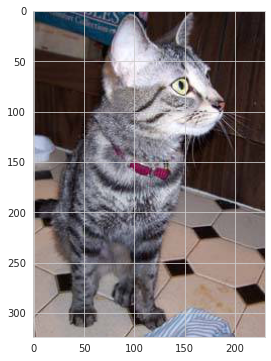

In [33]:
plt.imshow(cat_img)

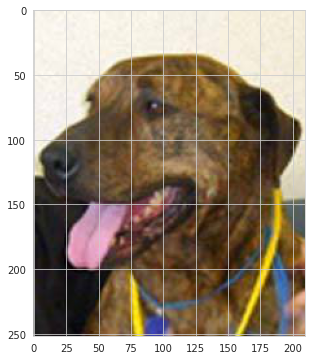

In [34]:
plt.imshow(dog_img)

In [35]:
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class

  random_image = random.sample(os.listdir(target_folder), 1)

  img = imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") 

  return img

Image shape: (375, 499, 3)


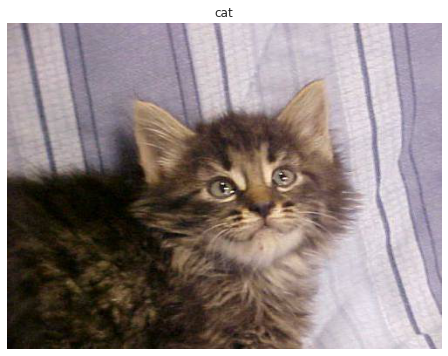

In [36]:
img = view_random_image(target_dir=train_path, target_class="cat")
                        

Image shape: (374, 500, 3)


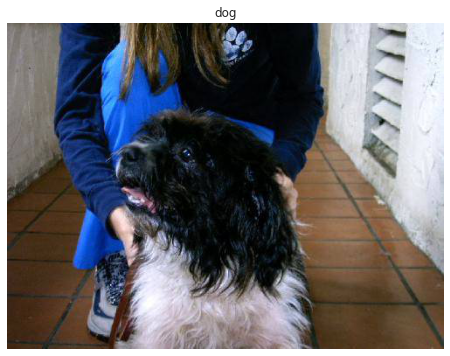

In [37]:
img = view_random_image(target_dir=train_path,
                        target_class="dog")

Image shape: (200, 140, 3)


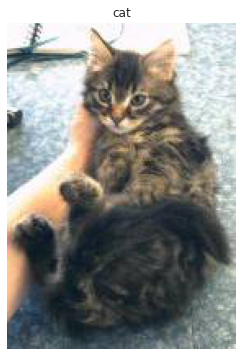

In [38]:
import random
img = view_random_image(target_dir=train_path,
                        target_class=random.choice(class_names)) 

# Data Preprocessing

## Defining Input Shape

**Let's decide on the final dimension of these images.**

In [39]:
cat_img.shape

(324, 230, 3)

In [40]:
dog_img.shape

(252, 210, 3)

In [41]:
x = [imread(train_path+'cat/'+image).shape[0] for image in os.listdir(train_path+'cat')]
y = [imread(train_path+'cat/'+image).shape[1] for image in os.listdir(train_path+'cat')]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


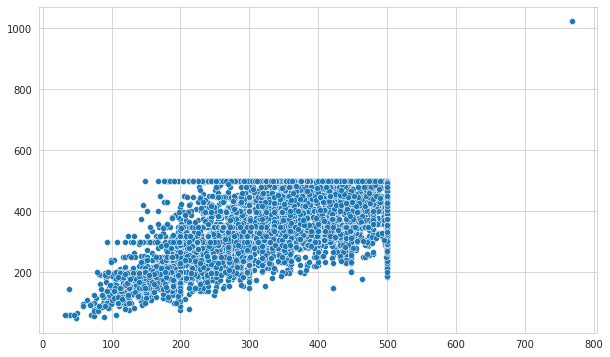

In [42]:
sns.scatterplot(x,y);

In [43]:
np.mean(x), np.median(x)

(356.46712, 374.0)

In [44]:
np.mean(y), np.median(y)

(410.52264, 470.0)

In [45]:
image_shape = (128,128,3)

## Scalling

**Let's check the images if they are needed to be scaled or not**

In [46]:
cat_img.max()

255

In [47]:
cat_img.min()

0

In [48]:
dog_img.max()

255

In [49]:
dog_img.min()

0

## Image Data Generator

**Image Manipulation**

We can use the ImageDataGenerator to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. ImageDataGenerator does the followings.

* Accepts a batch of images used for training.
* Applies a series of random transformations to each image in the batch.
* Replaces the original batch with randomly transformed batch.
* Training the CNN on this randomly transformed batch.

The goal of applying data augmentation is to have a more generalized model.

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [51]:
image_gen = ImageDataGenerator(rotation_range=15, 
                               width_shift_range=0.10, 
                               height_shift_range=0.10,
                               rescale=1/255,                                
                               shear_range=0.1, 
                               zoom_range=0.1, 
                               horizontal_flip=True, 
                               fill_mode='nearest')

In [52]:
image_gen2 = ImageDataGenerator(rescale=1/255)

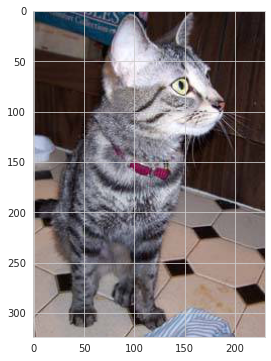

In [53]:
plt.imshow(cat_img);

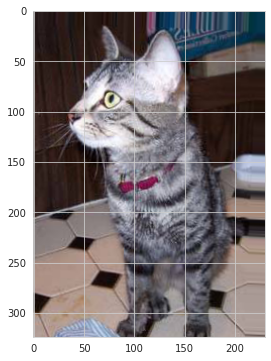

In [54]:
plt.imshow(image_gen.random_transform(cat_img));

### Taking the path to a directory & Generating batches of augmented data

flow_from_directory function works with images organized in sub-directories. Your directories should include only one class of images, so one folder per class of images.

In [55]:
image_gen.flow_from_directory(train_path)

Found 17526 images belonging to 2 classes.


In [56]:
image_gen.flow_from_directory(val_path)

Found 2290 images belonging to 2 classes.


In [57]:
image_gen.flow_from_directory(test_path)

Found 0 images belonging to 0 classes.


In [58]:
batch_size = 32

In [59]:
train_image_gen = image_gen.flow_from_directory(directory=train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='binary',
                                                shuffle=True)

Found 17526 images belonging to 2 classes.


In [60]:
val_image_gen = image_gen.flow_from_directory(directory=val_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=False)

Found 2290 images belonging to 2 classes.


In [61]:
train_image_gen.class_indices

{'cat': 0, 'dog': 1}

In [62]:
train_image_gen[0][0].shape

(32, 128, 128, 3)

In [63]:
len(train_image_gen), len(val_image_gen)

(548, 72)

In [64]:
len(train_image_gen)*batch_size, len(val_image_gen)*batch_size 

(17536, 2304)

In [65]:
images, labels = train_image_gen.next() 
len(images), len(labels)

(32, 32)

In [66]:
images, labels = val_image_gen.next() 
len(images), len(labels)

(32, 32)

# Modelling-1

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [68]:
model1 = Sequential()

model1.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())

model1.add(Dense(128))
model1.add(Activation('relu'))

model1.add(Dense(64))
model1.add(Activation('relu'))

model1.add(Dense(1))
model1.add(Activation('sigmoid'))

model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [69]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [70]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights = True)

In [71]:
model1.fit(train_image_gen,
          epochs=10,
          steps_per_epoch=len(train_image_gen),
          validation_data=val_image_gen,
          validation_steps=len(val_image_gen),
          callbacks=[early_stop])

Epoch 1/10
548/548 [==============================] - 138s 231ms/step - loss: 0.5959 - accuracy: 0.7132 - val_loss: 0.7423 - val_accuracy: 0.5328
Epoch 2/10
548/548 [==============================] - 126s 231ms/step - loss: 0.5274 - accuracy: 0.7461 - val_loss: 0.6039 - val_accuracy: 0.7135
Epoch 3/10
548/548 [==============================] - 126s 229ms/step - loss: 0.4728 - accuracy: 0.7803 - val_loss: 0.5646 - val_accuracy: 0.7017
Epoch 4/10
548/548 [==============================] - 126s 229ms/step - loss: 0.4235 - accuracy: 0.8106 - val_loss: 0.5691 - val_accuracy: 0.7349
Epoch 5/10
548/548 [==============================] - 124s 226ms/step - loss: 0.4017 - accuracy: 0.8198 - val_loss: 0.4737 - val_accuracy: 0.7843
Epoch 6/10
548/548 [==============================] - 126s 229ms/step - loss: 0.3723 - accuracy: 0.8351 - val_loss: 0.4541 - val_accuracy: 0.7869
Epoch 7/10
548/548 [==============================] - 125s 227ms/step - loss: 0.3505 - accuracy: 0.8462 - val_loss: 0.4486 -

In [72]:
summary = pd.DataFrame(model1.history.history)

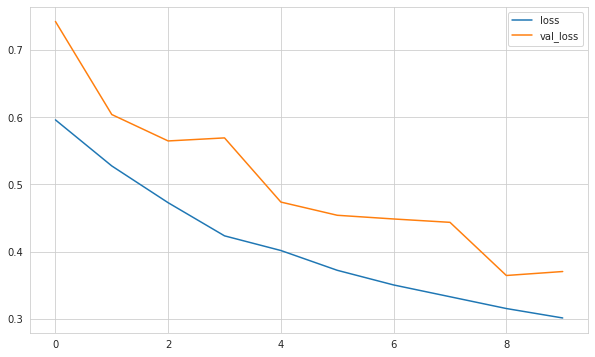

In [73]:
summary[["loss", "val_loss"]].plot();

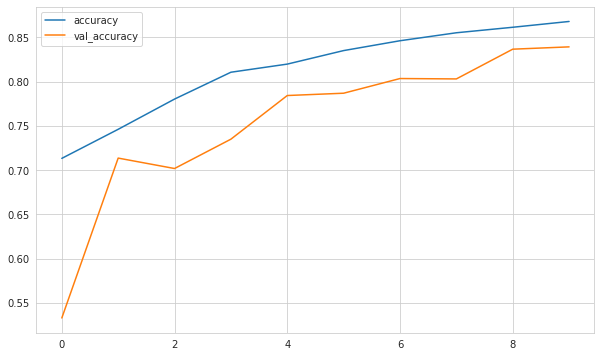

In [74]:
summary[["accuracy", "val_accuracy"]].plot();

# Modelling-2

In [75]:
model2 = Sequential()

model2.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())

model2.add(Dense(128))
model2.add(Activation('relu'))

model2.add(Dense(128))
model2.add(Activation('relu'))

model2.add(Dense(1))
model2.add(Activation('sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [76]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 32)       128       
 hNormalization)                                                 
                                                      

In [77]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)

In [78]:
model2.fit(train_image_gen,
          epochs=15,
          steps_per_epoch=len(train_image_gen),
          validation_data=val_image_gen,
          validation_steps=len(val_image_gen),
          callbacks=[early_stop])

Epoch 1/15
548/548 [==============================] - 127s 231ms/step - loss: 0.5384 - accuracy: 0.7498 - val_loss: 0.9264 - val_accuracy: 0.5991
Epoch 2/15
548/548 [==============================] - 131s 239ms/step - loss: 0.4191 - accuracy: 0.8118 - val_loss: 0.4774 - val_accuracy: 0.7747
Epoch 3/15
548/548 [==============================] - 126s 229ms/step - loss: 0.3705 - accuracy: 0.8395 - val_loss: 0.4343 - val_accuracy: 0.7996
Epoch 4/15
548/548 [==============================] - 124s 227ms/step - loss: 0.3208 - accuracy: 0.8615 - val_loss: 0.4702 - val_accuracy: 0.7825
Epoch 5/15
548/548 [==============================] - 126s 230ms/step - loss: 0.2864 - accuracy: 0.8781 - val_loss: 0.4085 - val_accuracy: 0.8231
Epoch 6/15
548/548 [==============================] - 125s 227ms/step - loss: 0.2617 - accuracy: 0.8890 - val_loss: 0.4253 - val_accuracy: 0.8092
Epoch 7/15
548/548 [==============================] - 126s 230ms/step - loss: 0.2406 - accuracy: 0.8988 - val_loss: 0.3457 -

In [79]:
summary = pd.DataFrame(model2.history.history)

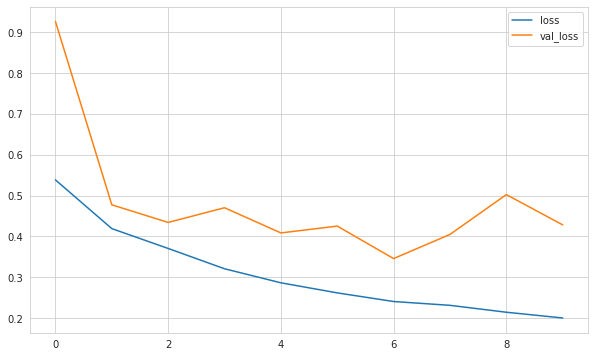

In [80]:
summary[["loss", "val_loss"]].plot();

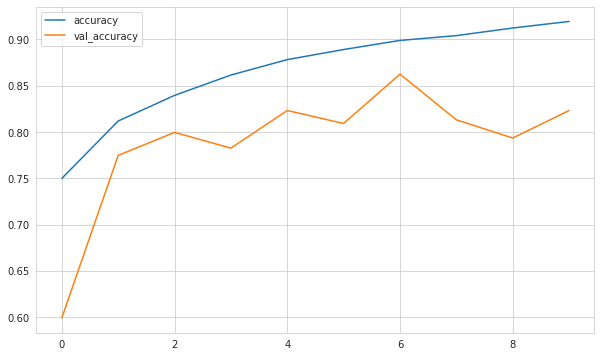

In [81]:
summary[["accuracy", "val_accuracy"]].plot();

# Modelling-3


In [82]:
model3 = Sequential()

model3.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', input_shape=image_shape, activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())

model3.add(Dense(128))
model3.add(Activation('relu'))

model3.add(Dense(128))
model3.add(Activation('relu'))

model3.add(Dense(1))
model3.add(Activation('sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [83]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                      

In [84]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)

In [85]:
model3.fit(train_image_gen,
          epochs=20,
          steps_per_epoch=len(train_image_gen),
          validation_data=val_image_gen,
          validation_steps=len(val_image_gen),
          callbacks=[early_stop])

Epoch 1/20
548/548 [==============================] - 135s 243ms/step - loss: 0.5647 - accuracy: 0.7378 - val_loss: 0.7171 - val_accuracy: 0.6201
Epoch 2/20
548/548 [==============================] - 130s 237ms/step - loss: 0.4437 - accuracy: 0.7940 - val_loss: 0.5189 - val_accuracy: 0.7498
Epoch 3/20
548/548 [==============================] - 132s 241ms/step - loss: 0.3808 - accuracy: 0.8281 - val_loss: 0.4494 - val_accuracy: 0.7799
Epoch 4/20
548/548 [==============================] - 132s 240ms/step - loss: 0.3260 - accuracy: 0.8560 - val_loss: 0.4306 - val_accuracy: 0.8070
Epoch 5/20
548/548 [==============================] - 137s 251ms/step - loss: 0.2748 - accuracy: 0.8835 - val_loss: 0.4164 - val_accuracy: 0.8135
Epoch 6/20
548/548 [==============================] - 131s 240ms/step - loss: 0.2529 - accuracy: 0.8930 - val_loss: 0.4581 - val_accuracy: 0.8035
Epoch 7/20
548/548 [==============================] - 129s 235ms/step - loss: 0.2246 - accuracy: 0.9054 - val_loss: 0.3016 -

In [86]:
summary = pd.DataFrame(model3.history.history)

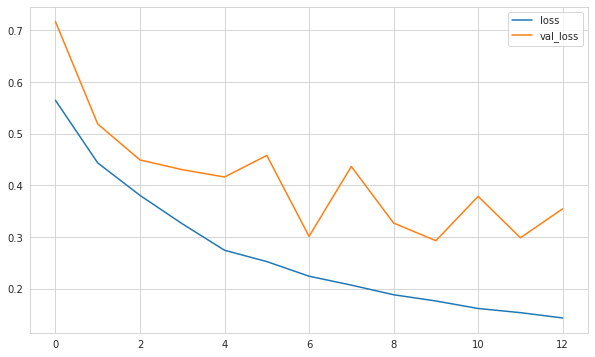

In [87]:
summary[["loss", "val_loss"]].plot();

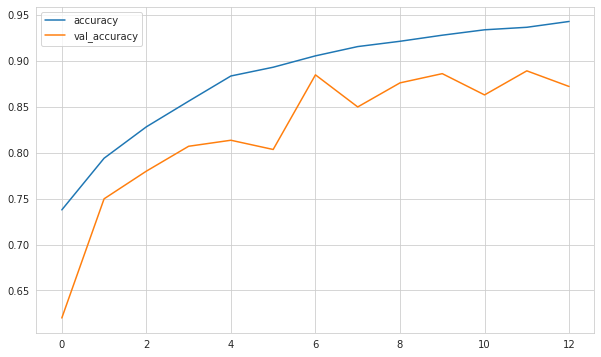

In [88]:
summary[["accuracy", "val_accuracy"]].plot();

# Evaluation on Test Data

In [89]:
from sklearn.metrics import classification_report, confusion_matrix

In [90]:
score = model3.evaluate(val_image_gen)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

72/72 [==============================] - 14s 197ms/step - loss: 0.2802 - accuracy: 0.8952
Test loss: 0.28017839789390564
Test accuracy: 0.8951964974403381


In [91]:
pred_prob = model3.predict(val_image_gen)
pred_prob

array([[1.0230785e-05],
       [5.5158150e-01],
       [6.1753513e-03],
       ...,
       [9.9265748e-01],
       [9.9986660e-01],
       [9.9544382e-01]], dtype=float32)

In [92]:
y_pred = pred_prob > 0.5
y_pred

array([[False],
       [ True],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [93]:
y_test = val_image_gen.classes

In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90      1219
           1       0.92      0.83      0.87      1071

    accuracy                           0.89      2290
   macro avg       0.89      0.88      0.88      2290
weighted avg       0.89      0.89      0.89      2290



In [95]:
confusion_matrix(y_test, y_pred)

array([[1137,   82],
       [ 179,  892]])

In [97]:
model3.save('cat_dog_classificator.h5')

# Prediction-1

In [98]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [99]:
model=load_model('cat_dog_classificator.h5')

In [100]:
img_path = "/content/data/test/10018.jpg"

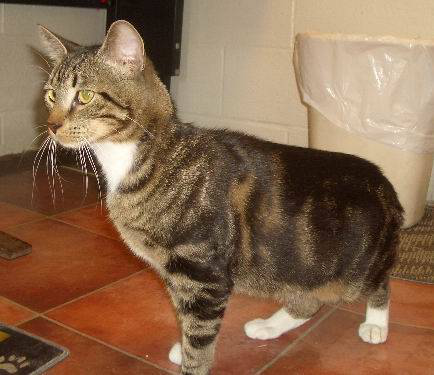

In [101]:
img=image.load_img(img_path)
img

In [102]:
img = np.array(img)

In [103]:
img.shape

(375, 434, 3)

In [104]:
resized_img = image.smart_resize(img, (128, 128))

In [105]:
resized_img.max()

255.0

In [106]:
resized_img = resized_img / 255

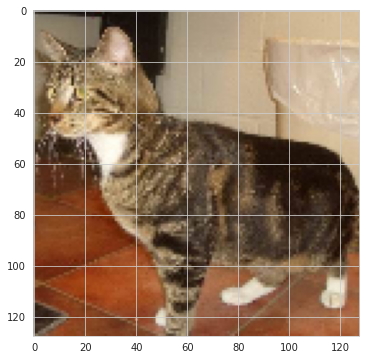

In [107]:
plt.imshow(resized_img)

In [108]:
resized_img=np.expand_dims(resized_img, axis=0)
resized_img.shape

(1, 128, 128, 3)

In [109]:
model.predict(resized_img)

array([[0.00433426]], dtype=float32)

In [110]:
val_image_gen.class_indices

{'cat': 0, 'dog': 1}

# Prediction-2

In [111]:
random_image = random.sample(os.listdir(test_path), 1)
random_image

['5703.jpg']

In [112]:
image_path = test_path + random_image[0]
image_path

'data/test/5703.jpg'

In [113]:
my_image = image.load_img(image_path, target_size=image_shape)

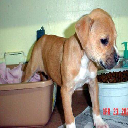

In [114]:
my_image

In [115]:
type(my_image)

PIL.Image.Image

In [116]:
my_image = image.img_to_array(my_image)

In [117]:
my_image.max()

255.0

In [118]:
my_image = my_image / 255

In [119]:
my_image.shape

(128, 128, 3)

In [120]:
my_image = np.expand_dims(my_image, axis=0)

In [121]:
my_image.shape

(1, 128, 128, 3)

In [122]:
model.predict(my_image)

array([[0.99530065]], dtype=float32)

In [123]:
train_image_gen.class_indices

{'cat': 0, 'dog': 1}

In [124]:
def pred_and_plot(model, img_size):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    random_image = random.sample(os.listdir(test_path), 1)
    img_path = test_path + random_image[0]
    img = image.load_img(img_path, target_size=img_size)
    img = np.array(img)
    if img.max() > 1:
        img = img/255
  
    # Make a prediction
    pred = model.predict(np.expand_dims(img, axis=0))
    print("prediction_probability: ", pred.max())

    # Get the predicted class
    if len(pred[0]) > 1: # check for multi-class
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

prediction_probability:  0.0007796732


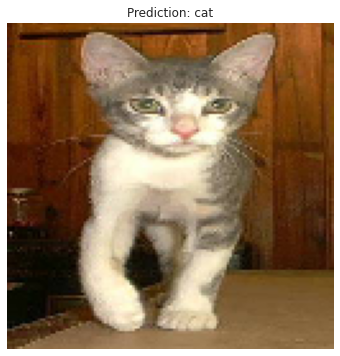

In [125]:
pred_and_plot(model, image_shape[:2])

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="Rossum"></p>